Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')

Loading the dataset from vendor summary table in inventory db.

In [3]:
conn = sqlite3.connect("inventory.db")

In [4]:
df = pd.read_sql("select * from vendor_summary", conn)

# Exploratory Data Analysis
- Previously, we examined the various tables in the database to identify key variables, understanding their relationships, and determine which ones should be included in the final analysis.
- In the phrase of EDA, we will analyze the resultant table to gain insights into the distribution of each column. This will help us understand data patterns, identify anomalies, and ensure data quality before proceeding with further analysis.

In [50]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
VendorNumber,8564.0,10107.07,17635.71,2.00,3664.00,7153.00,9552.00,201359.00
Brand,8564.0,17614.67,12946.13,58.00,5375.75,17606.00,24935.25,90631.00
PurchasePrice,8564.0,21.78,81.19,0.36,6.66,10.06,17.85,3352.93
Volume,8564.0,864.33,724.24,50.00,750.00,750.00,750.00,20000.00
ActualPrice,8564.0,32.30,112.42,0.49,9.99,14.99,25.99,4559.99
TotalPurchasedQuantity,8564.0,3772.01,12276.96,1.00,42.00,431.00,2666.75,337660.00
TotalPurchasedDollar,8564.0,35887.25,136723.00,0.71,546.19,5018.40,26610.18,3811251.60
TotalSalesDollars,8564.0,51542.28,186071.49,1.98,1355.58,8483.78,40622.11,5101919.51
TotalSalesPrice,8564.0,22759.27,49305.27,0.99,584.79,4549.75,22595.25,672819.31
TotalSalesQuantity,8564.0,3748.98,12125.70,1.00,62.00,490.50,2675.00,334939.00


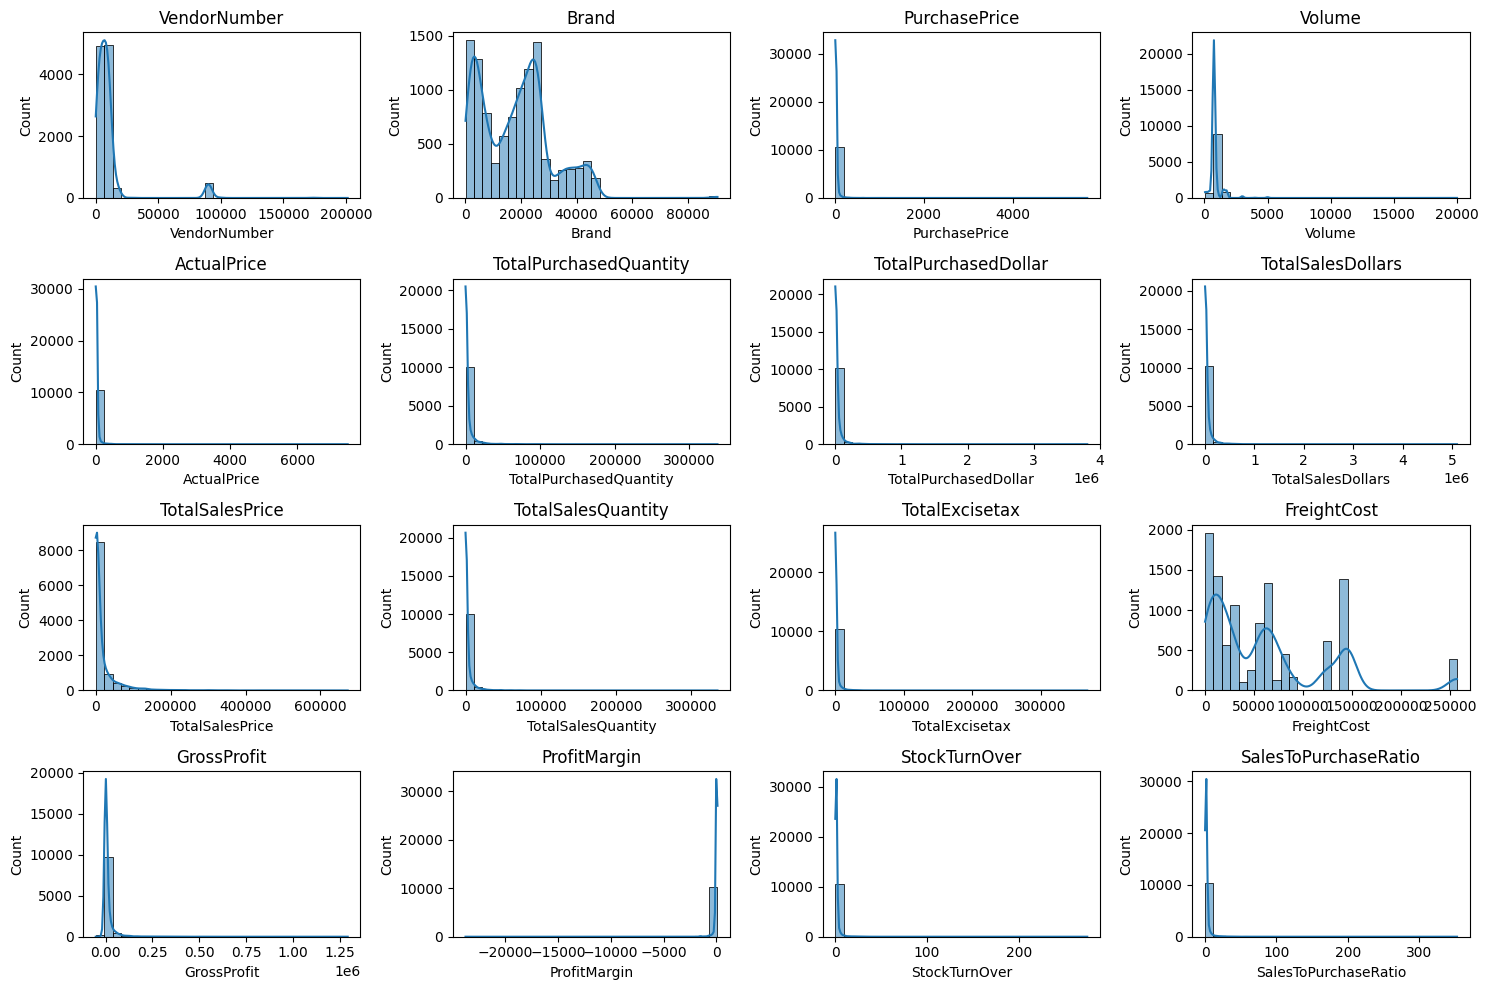

In [6]:
# distribution plot for numerical columns

numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

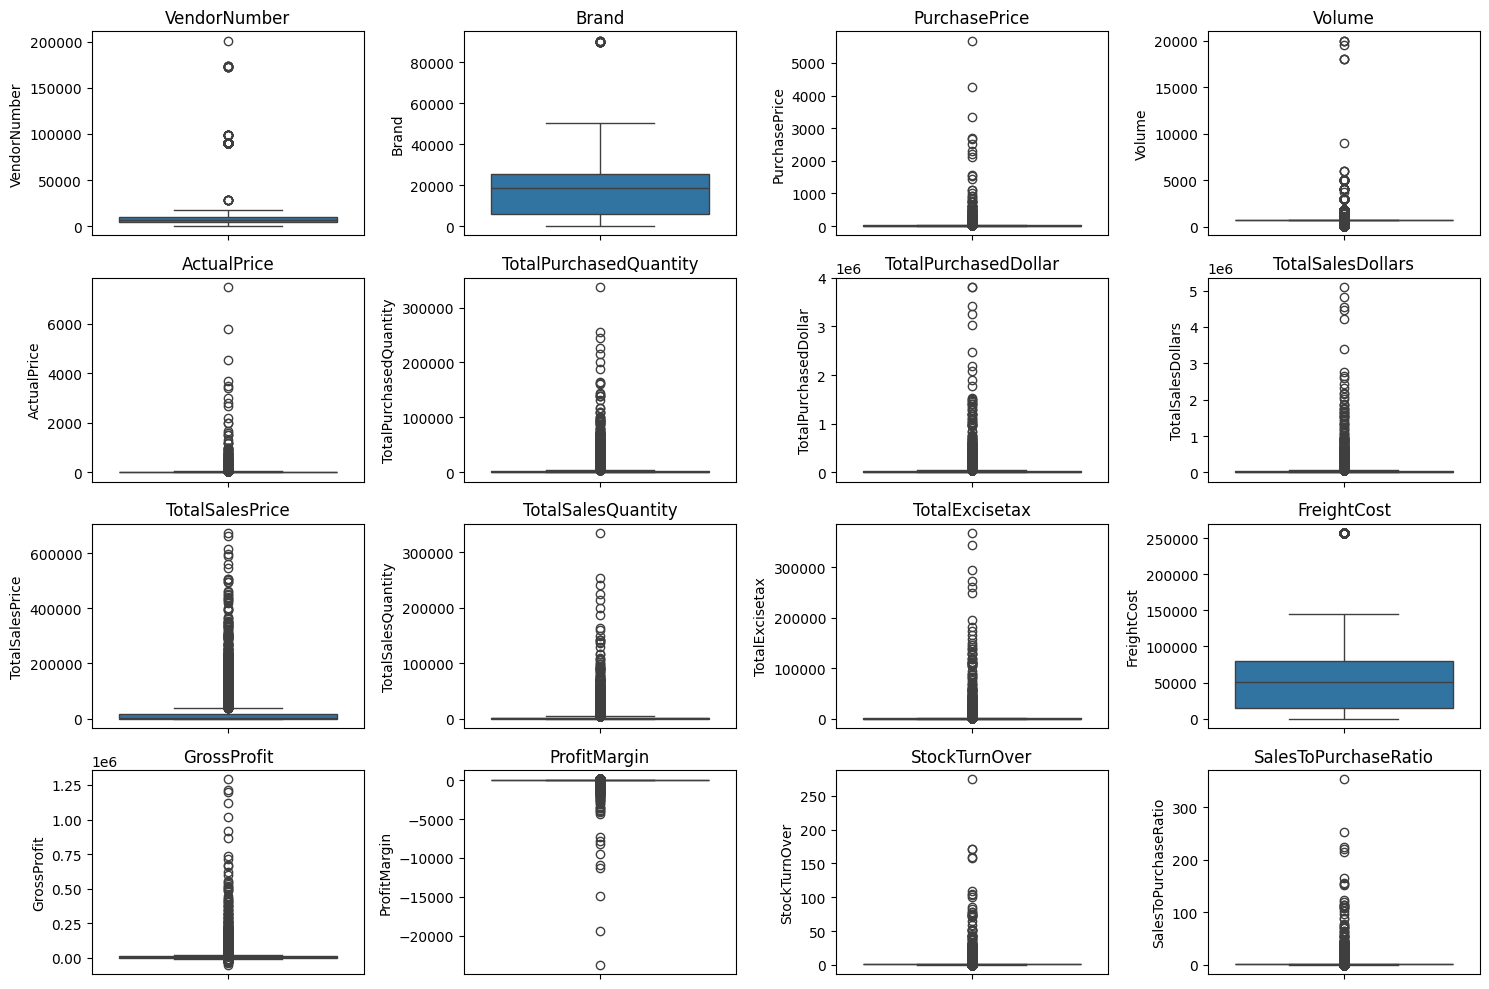

In [7]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.boxplot(y = df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Summary Statistics Insights
##### Negative & Zero Values:

- **Gross Profit:** Minimum value is **-52,002.78**, indicating losses. Some products or transactions may be selling at a loss due to high costs or selling at discounts lower than the purchase price.
- **Profit Margin:** Has a minimum of **-∞**, which suggests cases where revenue is zero or even lower than costs.
- **Total Sales Quantity & Sales Dollars:** Minimum values are **0**, meaning some products were purchased but never sold. These could be slow-moving or obsolete stock.

##### Outliers Indicated by High Standard Deviations:

- **Purchase & Actual Prices:** The max values (**5,681.81 & 7,499.99**) are significantly higher than the mean (**24.39 & 35.64**), indicating potential premium products.
- **Freight Cost:** Huge variation, from **0.09 to 257,032.07**, suggests logistics inefficiencies or bulk shipments.
- **Stock Turnover:** Ranges from **0 to 274.5**, implying some products sell extremely fast while others remain in stock indefinitely.  
  A value more than **1** indicates that sold quantity for that product is higher than purchased quantity due to either sales or being fulfilled from older stock.


In [8]:
# Filtering the data by removing inconsistency.
df = pd.read_sql("""
    select
        *   
    from vendor_summary
    where GrossProfit > 0 and
    ProfitMargin > 0 and 
    TotalSalesQuantity > 0
""", conn)

In [9]:
df

,VendorNumber,VendorName,Brand,Description,PurchasePrice,Volume,ActualPrice,TotalPurchasedQuantity,TotalPurchasedDollar,TotalSalesDollars,TotalSalesPrice,TotalSalesQuantity,TotalExcisetax,FreightCost,GrossProfit,ProfitMargin,StockTurnOver,SalesToPurchaseRatio
0,480,BACARDI USA INC,4357,Bacardi Oakheart Spiced Trav,7.46,750.0,9.99,1,7.46,399.60,369.63,40.0,31.58,89286.27,392.14,98.13,40.000000,53.57
1,480,BACARDI USA INC,5181,Leblon Cedilla Acai Liqueur,23.99,750.0,29.99,1,23.99,89.97,89.97,3.0,2.37,89286.27,65.98,73.34,3.000000,3.75
2,480,BACARDI USA INC,6916,St Germain Liqueur,11.10,200.0,14.99,1,11.10,374.75,314.79,25.0,5.25,89286.27,363.65,97.04,25.000000,33.76
3,516,BANFI PRODUCTS CORP,17172,Riunite Sweet White,4.10,750.0,5.99,1,4.10,161.73,131.78,27.0,2.98,8510.41,157.63,97.46,27.000000,39.45
4,516,BANFI PRODUCTS CORP,18807,C Y Toro Diablo Red,7.94,750.0,11.99,1,7.94,11.99,11.99,1.0,0.11,8510.41,4.05,33.78,1.000000,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,10000,MAJESTIC FINE WINES,6570,Kendall Jackson Chard Vt RSV,6.77,750.0,10.99,215668,1460072.36,2326007.78,189608.96,214238.0,24083.77,17587.59,865935.42,37.23,0.993369,1.59
8560,3960,DIAGEO NORTH AMERICA INC,3606,Smirnoff Raspberry Vodka,0.74,50.0,0.99,226085,167302.90,223483.59,21764.16,225741.0,11842.95,257032.07,56180.69,25.14,0.998478,1.34
8561,8004,SAZERAC CO INC,5111,Dr McGillicuddy's Mentholmnt,0.72,50.0,0.99,244654,176150.88,239543.37,20941.47,241963.0,12692.41,50293.62,63392.49,26.46,0.989001,1.36
8562,3960,DIAGEO NORTH AMERICA INC,1892,Yukon Jack,0.72,50.0,0.99,254824,183473.28,250837.29,20741.49,253371.0,13295.86,257032.07,67364.01,26.86,0.994298,1.37


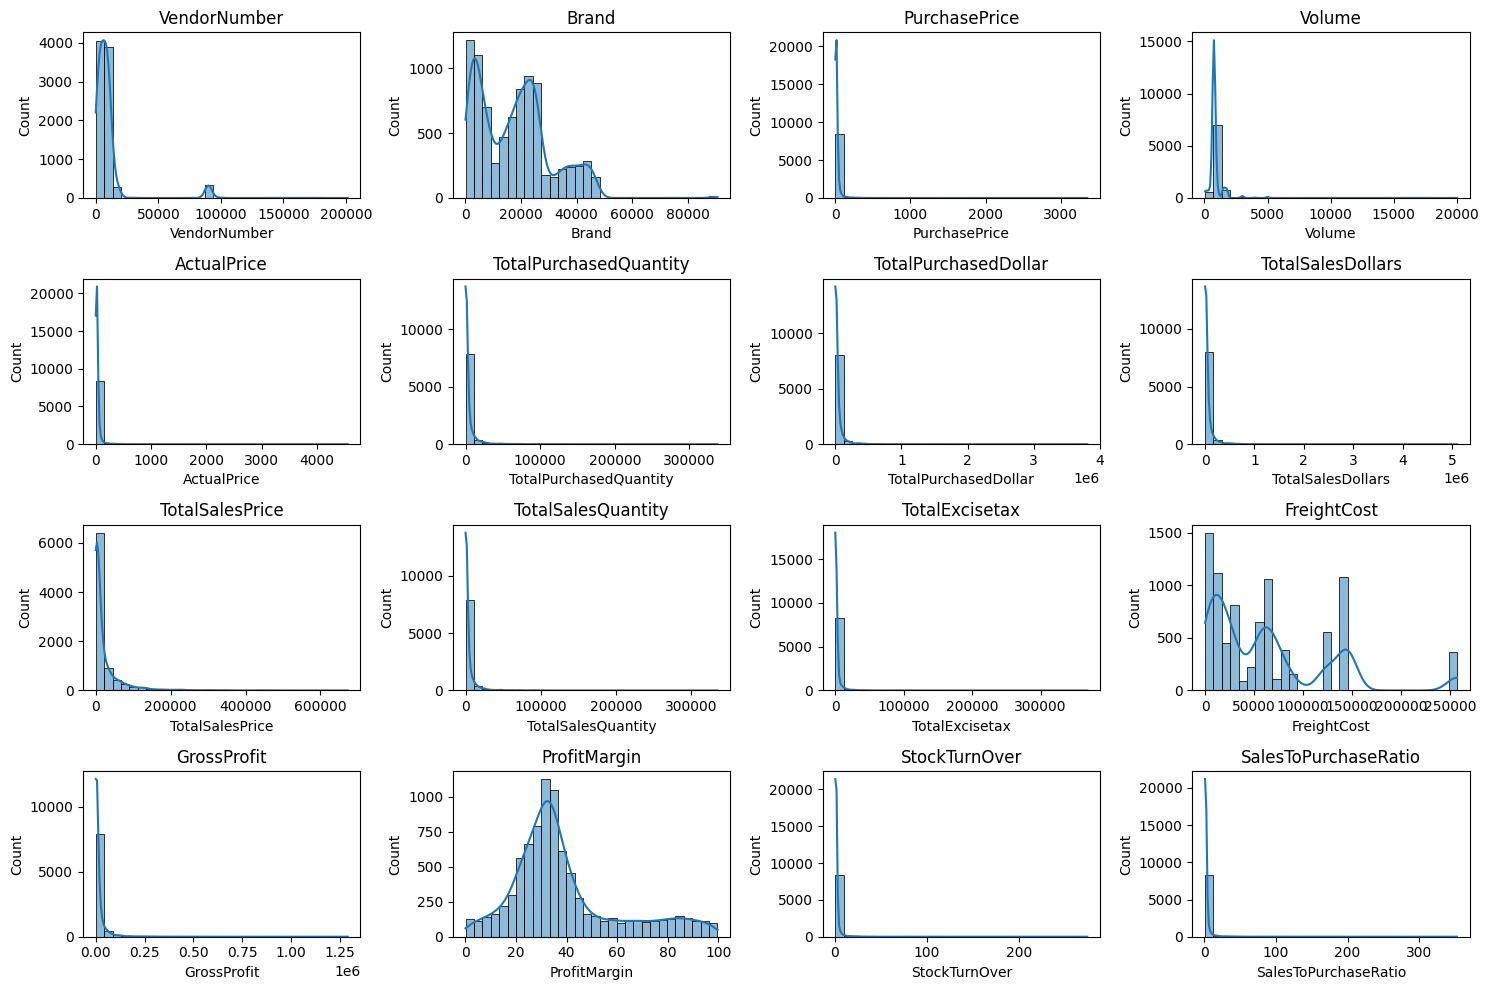

In [10]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

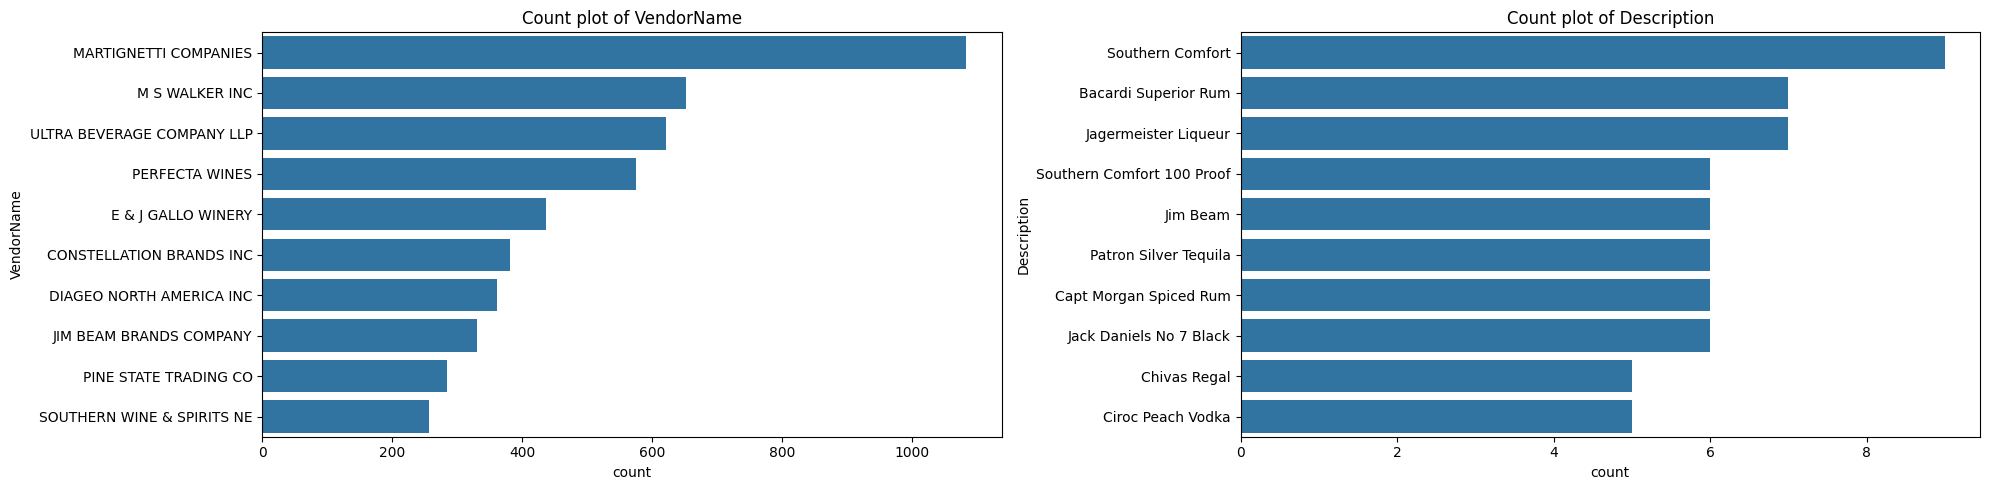

In [11]:
categorical_cols = ['VendorName', "Description"]

plt.figure(figsize=(20,5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10]) # top 10 categories
    plt.title(f"Count plot of {col}")

plt.tight_layout()
plt.show()

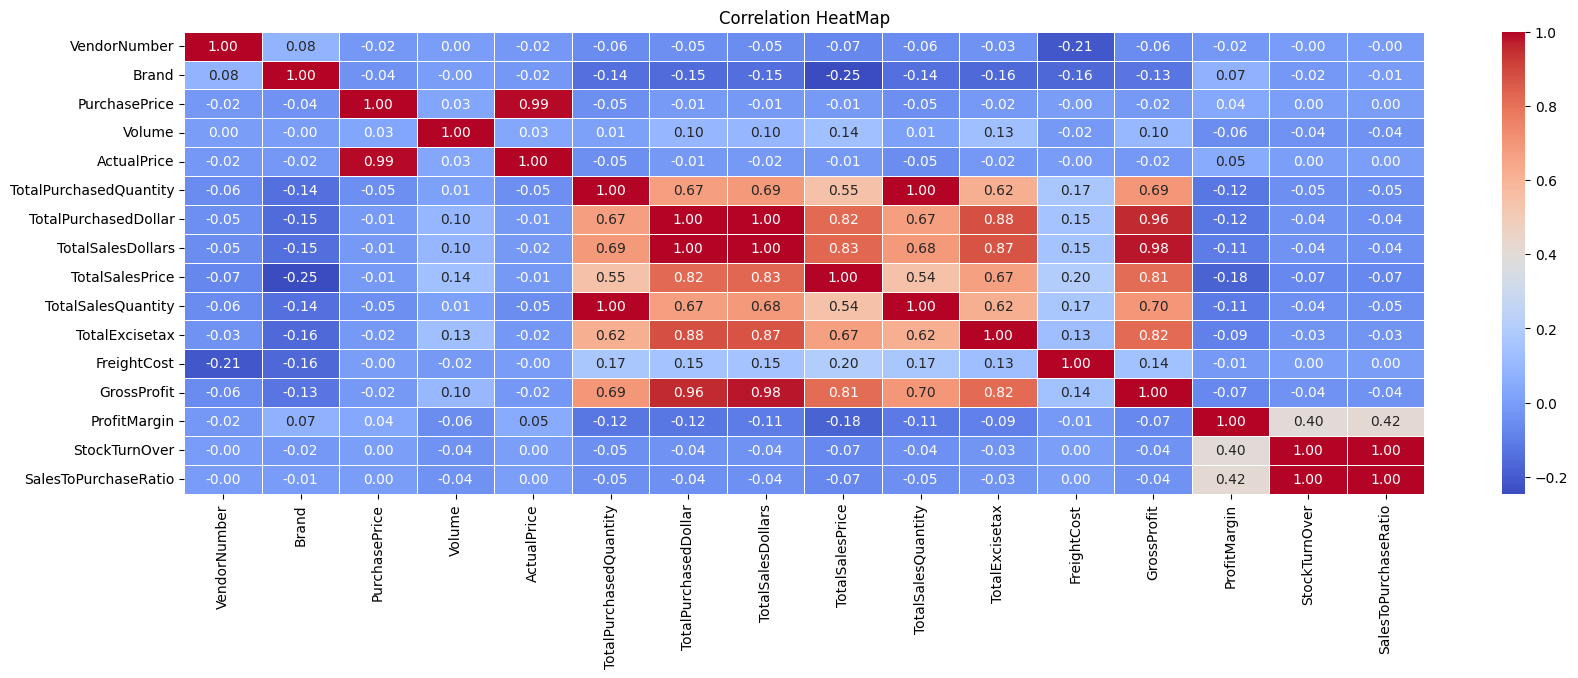

In [12]:
# Correlation HeatMap

plt.figure(figsize=(20,6))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation HeatMap")
plt.show()

### Correlation Insights

- **PurchasePrice** has weak correlations with **TotalSalesDollars (-0.012)** and **GrossProfit (-0.016)**, suggesting that price variations do not significantly impact sales revenue or profit.  

- **Strong correlation** between **total purchase quantity** and **total sales quantity (0.999)** confirms efficient inventory turnover.  

- **Negative correlation** between **profit margin & total sales price (-0.179)** suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressures.  

- **StockTurnover** has weak negative correlations with both **GrossProfit (-0.038)** and **ProfitMargin (-0.055)**, indicating that faster turnover does not necessarily result in higher profitability.  


### Data Analysis


Identify Brands that needs Promotional or Pricing Adjustment which exhibits lower sales performance but higher profit margins.

In [13]:
brand_performance = df.groupby("Description").agg({
    'TotalSalesDollars':'sum',
    'ProfitMargin': 'mean'
}).reset_index()

In [14]:
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance["ProfitMargin"].quantile(0.85)

In [15]:
low_sales_threshold

np.float64(560.299)

In [16]:
high_margin_threshold

np.float64(64.96799999999995)

In [17]:
target_brand = brand_performance[(brand_performance["TotalSalesDollars"] < low_sales_threshold) & (brand_performance["ProfitMargin"]> high_margin_threshold)].sort_values("TotalSalesDollars")

In [18]:
print("Brand with Low Sales Performance but with high Profit Margin")
target_brand

Brand with Low Sales Performance but with high Profit Margin


,Description,TotalSalesDollars,ProfitMargin
6199,Santa Rita Organic Svgn Bl,9.99,66.47
2369,Debauchery Pnt Nr,11.58,65.98
2070,Concannon Glen Ellen Wh Zin,15.95,83.45
2188,Crown Royal Apple,27.86,89.81
6237,Sauza Sprklg Wild Berry Marg,27.96,82.15
...,...,...,...
5074,Nanbu Bijin Southern Beauty,535.68,76.75
2271,Dad's Hat Rye Whiskey,538.89,81.85
57,A Bichot Clos Marechaudes,539.94,67.74
6245,Sbragia Home Ranch Merlot,549.75,66.44


In [19]:
brand_performance = brand_performance[brand_performance["TotalSalesDollars"] < 10000] # for better visualization

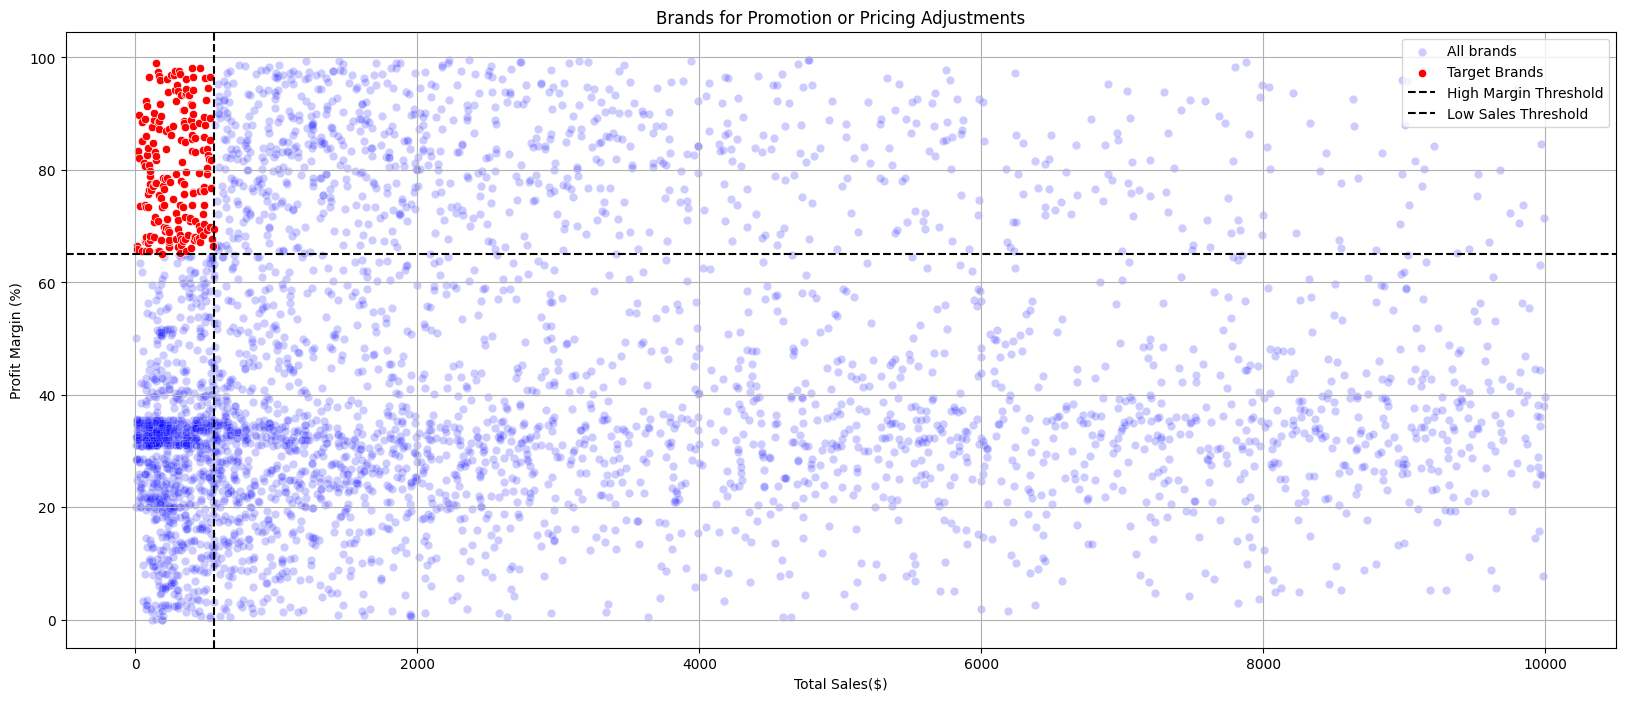

In [20]:
plt.figure(figsize=(20,8))

sns.scatterplot(data=brand_performance, x="TotalSalesDollars", y="ProfitMargin", color="blue", label="All brands",alpha=0.2)
sns.scatterplot(data=target_brand, x="TotalSalesDollars", y="ProfitMargin", label="Target Brands", color="red")

plt.axhline(high_margin_threshold, linestyle="--", color='black', label='High Margin Threshold')
plt.axvline(low_sales_threshold, linestyle="--", color='black', label='Low Sales Threshold')

plt.xlabel("Total Sales($)")
plt.ylabel("Profit Margin (%)")
plt.title("Brands for Promotion or Pricing Adjustments")
plt.legend()
plt.grid(True)
plt.show()

Which Vendors and Brands demonstrate the highest sales performance?

In [21]:
def format_dollar(value):
    if value >= 1_000_000:
        return f"{value/1_000_000:.2f} M"
    elif value >= 1_000:
        return f"{value/1_000:.2f} K"
    else:
        return str(value)

In [22]:
topvendors = df.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10).round(2)
topBrands= df.groupby('Description')['TotalSalesDollars'].sum().nlargest(10).round(2)

In [23]:
topvendors.apply(lambda x: format_dollar(x))

VendorName
DIAGEO NORTH AMERICA INC      67.99 M
MARTIGNETTI COMPANIES         39.33 M
PERNOD RICARD USA             32.06 M
JIM BEAM BRANDS COMPANY       31.42 M
BACARDI USA INC               24.85 M
CONSTELLATION BRANDS INC      24.22 M
E & J GALLO WINERY            18.40 M
BROWN-FORMAN CORP             18.25 M
ULTRA BEVERAGE COMPANY LLP    16.50 M
M S WALKER INC                14.71 M
Name: TotalSalesDollars, dtype: object

In [24]:
topBrands.apply(lambda x: format_dollar(x))

Description
Jack Daniels No 7 Black    7.96 M
Tito's Handmade Vodka      7.40 M
Grey Goose Vodka           7.21 M
Capt Morgan Spiced Rum     6.36 M
Absolut 80 Proof           6.24 M
Jameson Irish Whiskey      5.72 M
Ketel One Vodka            5.07 M
Baileys Irish Cream        4.15 M
Kahlua                     3.60 M
Tanqueray                  3.46 M
Name: TotalSalesDollars, dtype: object

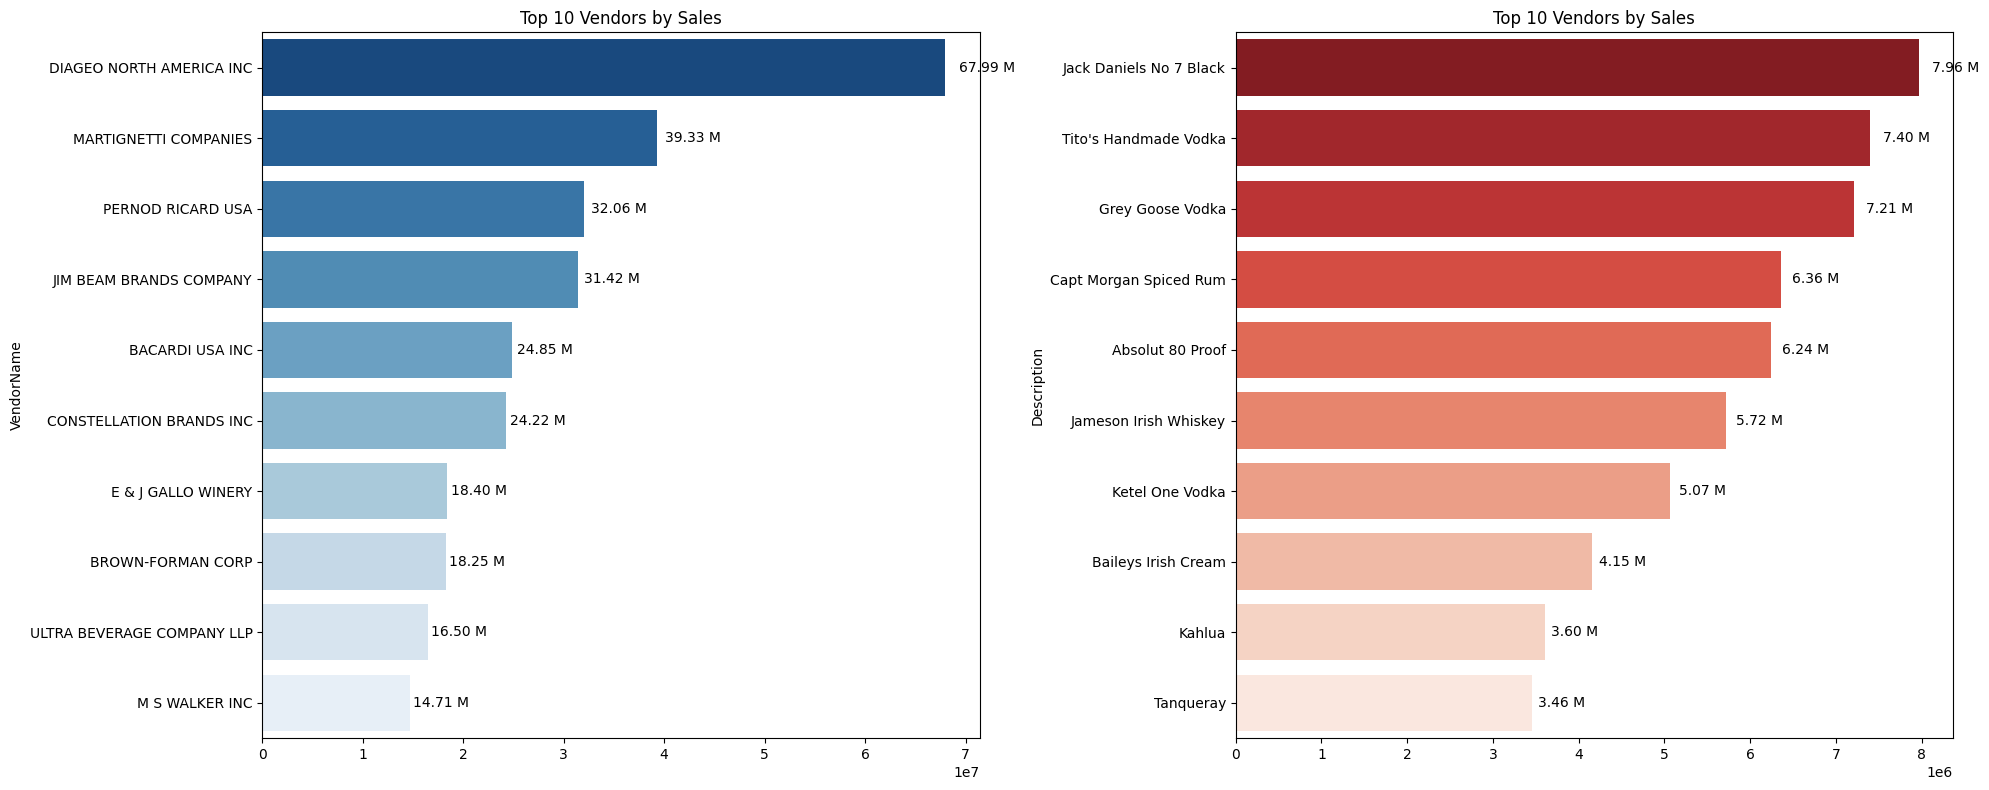

In [25]:
plt.figure(figsize=(20,8))
# Bar plot for vendors
plt.subplot(1,2,1)
ax1 = sns.barplot(y=topvendors.index, x=topvendors.values, palette='Blues_r')
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollar(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black'
            )


# Bar plot for Brands
plt.subplot(1,2,2)
ax2 = sns.barplot(y=topBrands.index, x=topBrands.values, palette='Reds_r')
plt.title("Top 10 Vendors by Sales")

for bar in ax2.patches:
    ax2.text(bar.get_width() + (bar.get_width() * 0.02),
             bar.get_y() + bar.get_height() / 2,
             format_dollar(bar.get_width()),
             ha='left', va='center', fontsize=10, color='black'
            )
    

plt.tight_layout()
plt.show()

Which vendors contribute the most to the total purchase dollars?

In [26]:
vendor_performance = df.groupby("VendorName").agg({
    "TotalPurchasedDollar": 'sum',
    "GrossProfit": 'sum',
    "TotalSalesDollars": 'sum'
}).round(2).reset_index()

vendor_performance

,VendorName,TotalPurchasedDollar,GrossProfit,TotalSalesDollars
0,ADAMBA IMPORTS INTL INC,446.16,258.37,704.53
1,ALISA CARR BEVERAGES,25698.12,78772.82,104470.94
2,ALTAMAR BRANDS LLC,11706.20,4000.61,15706.81
3,AMERICAN SPIRITS EXCHANGE,934.08,577.08,1511.16
4,AMERICAN VINTAGE BEVERAGE,104435.68,35167.85,139603.53
...,...,...,...,...
114,WEIN BAUER INC,42694.64,13522.49,56217.13
115,WESTERN SPIRITS BEVERAGE CO,298416.86,106837.97,405254.83
116,WILLIAM GRANT & SONS INC,5876538.26,1693337.94,7569876.20
117,WINE GROUP INC,5203801.17,3100242.11,8304043.28


In [27]:
vendor_performance['PurchaseContribution %'] = vendor_performance["TotalPurchasedDollar"] * 100 / vendor_performance["TotalPurchasedDollar"].sum()

In [28]:
vendor_performance = vendor_performance.sort_values(by='PurchaseContribution %', ascending=False).round(2)

In [29]:
vendor_performance['TotalPurchasedDollar'] = vendor_performance['TotalPurchasedDollar'].apply(format_dollar)
vendor_performance['GrossProfit'] = vendor_performance['GrossProfit'].apply(format_dollar)
vendor_performance['TotalSalesDollars'] = vendor_performance['TotalSalesDollars'].apply(format_dollar)

In [30]:
topvendors = vendor_performance.head(10)
topvendors

,VendorName,TotalPurchasedDollar,GrossProfit,TotalSalesDollars,PurchaseContribution %
25,DIAGEO NORTH AMERICA INC,50.10 M,17.89 M,67.99 M,16.30
57,MARTIGNETTI COMPANIES,25.50 M,13.83 M,39.33 M,8.30
68,PERNOD RICARD USA,23.85 M,8.21 M,32.06 M,7.76
46,JIM BEAM BRANDS COMPANY,23.49 M,7.93 M,31.42 M,7.64
6,BACARDI USA INC,17.43 M,7.42 M,24.85 M,5.67
20,CONSTELLATION BRANDS INC,15.27 M,8.95 M,24.22 M,4.97
11,BROWN-FORMAN CORP,13.24 M,5.01 M,18.25 M,4.31
30,E & J GALLO WINERY,12.07 M,6.33 M,18.40 M,3.93
106,ULTRA BEVERAGE COMPANY LLP,11.17 M,5.34 M,16.50 M,3.63
53,M S WALKER INC,9.76 M,4.94 M,14.71 M,3.18


In [31]:
topvendors["Cummulative Contribution"] = topvendors['PurchaseContribution %'].cumsum().round(2)
topvendors

,VendorName,TotalPurchasedDollar,GrossProfit,TotalSalesDollars,PurchaseContribution %,Cummulative Contribution
25,DIAGEO NORTH AMERICA INC,50.10 M,17.89 M,67.99 M,16.30,16.30
57,MARTIGNETTI COMPANIES,25.50 M,13.83 M,39.33 M,8.30,24.60
68,PERNOD RICARD USA,23.85 M,8.21 M,32.06 M,7.76,32.36
46,JIM BEAM BRANDS COMPANY,23.49 M,7.93 M,31.42 M,7.64,40.00
6,BACARDI USA INC,17.43 M,7.42 M,24.85 M,5.67,45.67
20,CONSTELLATION BRANDS INC,15.27 M,8.95 M,24.22 M,4.97,50.64
11,BROWN-FORMAN CORP,13.24 M,5.01 M,18.25 M,4.31,54.95
30,E & J GALLO WINERY,12.07 M,6.33 M,18.40 M,3.93,58.88
106,ULTRA BEVERAGE COMPANY LLP,11.17 M,5.34 M,16.50 M,3.63,62.51
53,M S WALKER INC,9.76 M,4.94 M,14.71 M,3.18,65.69


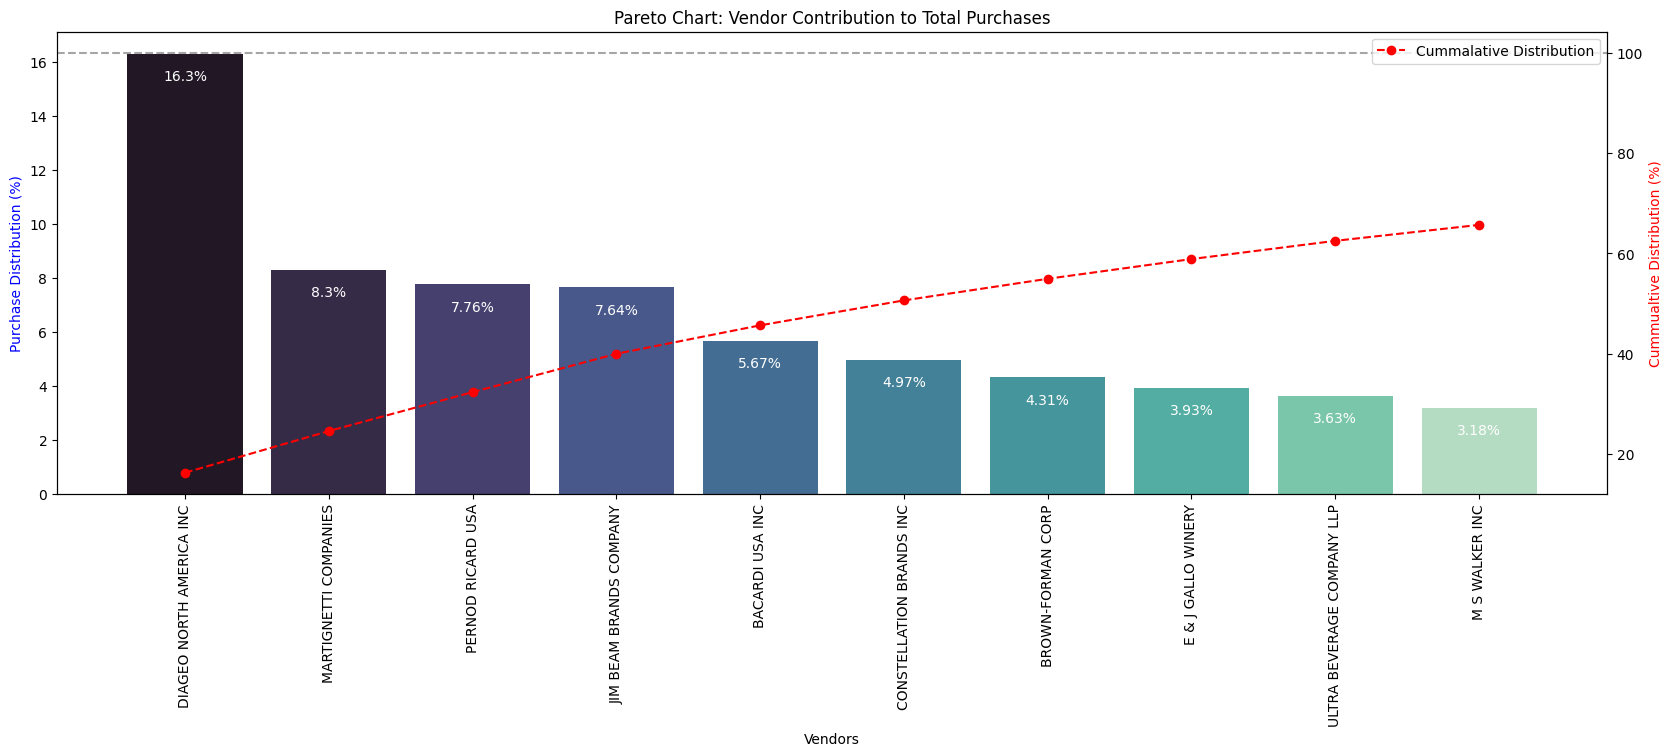

In [32]:
fig,ax1 = plt.subplots(figsize=(20,6))

# Bar plot for purchase distribution
sns.barplot(y=topvendors["PurchaseContribution %"], x=topvendors["VendorName"], palette='mako', ax=ax1)

for i, value in enumerate(topvendors["PurchaseContribution %"]):
    ax1.text(i, value-1, str(value)+'%', ha='center', fontsize=10, color='white')


# Line plot for Cummulative distribution
ax2 = ax1.twinx()
ax2.plot(topvendors["VendorName"], topvendors["Cummulative Contribution"], color='red', marker='o', linestyle='dashed', label='Cummalative Distribution')

ax1.set_xticklabels(topvendors['VendorName'], rotation=90)
ax1.set_ylabel("Purchase Distribution (%)", color="blue")
ax2.set_ylabel("Cummualtive Distribution (%)", color="red")
ax1.set_xlabel("Vendors")
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)
ax2.legend(loc='upper right')
plt.show()

How much of total Procurement is dependent on the top vendors?

In [33]:
print(f"Total Purchase Contribution of top 10 vendors is {topvendors['PurchaseContribution %'].sum().round(2)} %")

Total Purchase Contribution of top 10 vendors is 65.69 %


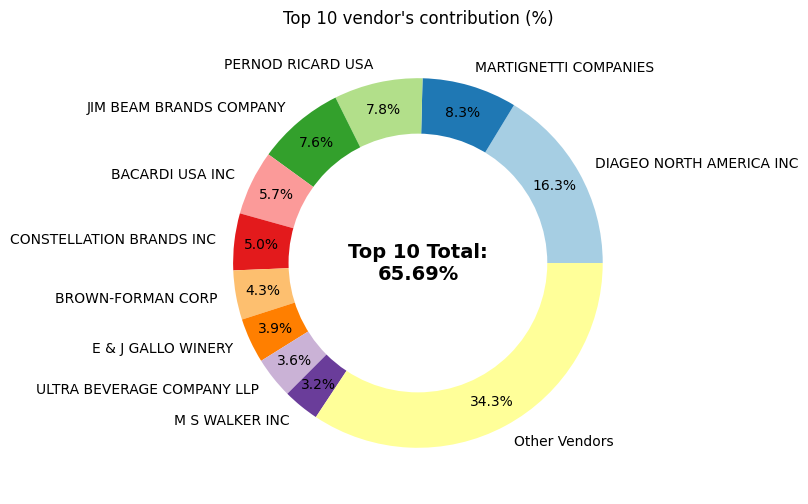

In [34]:
vendors = list(topvendors["VendorName"].values)
purchase_contribution = list(topvendors['PurchaseContribution %'].values)
total_contribution = sum(purchase_contribution)
remaining_contribution = 100 - total_contribution

#appending other vendors
vendors.append("Other Vendors")
purchase_contribution.append(remaining_contribution)

# Donut Chart
fig, ax = plt.subplots(figsize=(10,6))

wedges, texts, autotexts = ax.pie(purchase_contribution, labels=vendors, autopct='%1.1f%%', startangle=0, pctdistance=0.85, colors=plt.cm.Paired.colors)

# Draw a white circle in the center to give a donut effect.
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

# Adding total contribution annotation in the center.
plt.text(0,0,f"Top 10 Total:\n{total_contribution:.2f}%", fontsize=14, fontweight='bold', ha='center', va='center')

plt.title("Top 10 vendor's contribution (%)")
plt.show()

Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [35]:
df["UnitPurchasePrice"] = df["TotalPurchasedDollar"] / df["TotalPurchasedQuantity"]

In [36]:
df["OrderSize"] = pd.qcut(df["TotalPurchasedQuantity"], q=3, labels=['Small', 'Medium', 'Large'])

In [37]:
df.groupby("OrderSize")[['UnitPurchasePrice']].mean().round(2)

,UnitPurchasePrice
OrderSize,
Small,39.07
Medium,15.49
Large,10.78


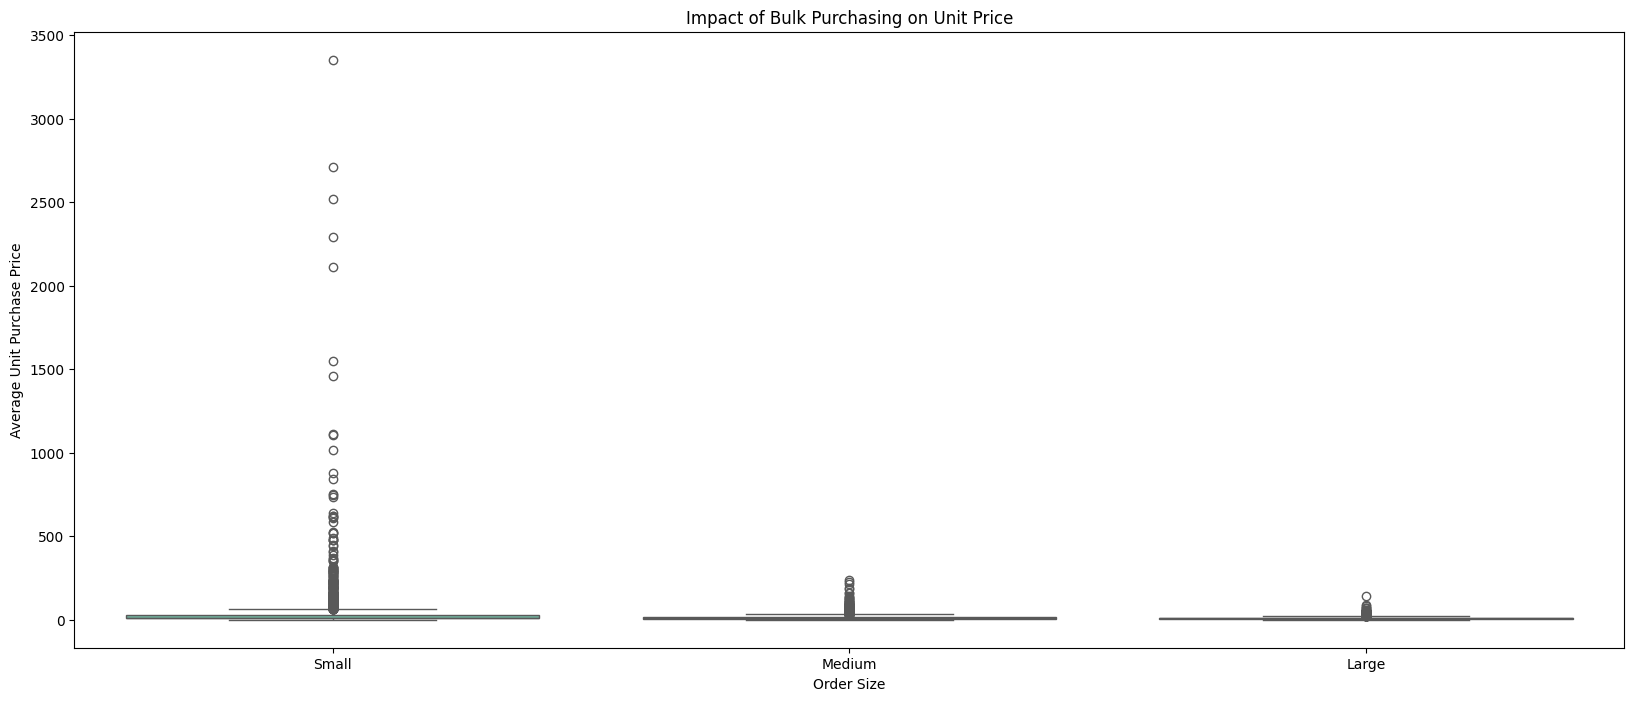

In [38]:
plt.figure(figsize=(20,8))
sns.boxplot(data=df, x="OrderSize",y="UnitPurchasePrice", palette='Set2')
plt.title("Impact of Bulk Purchasing on Unit Price")
plt.xlabel("Order Size")
plt.ylabel("Average Unit Purchase Price")
plt.show()

- Vendors purchasing in bulk (large order sizes) receive the lowest unit price ($10.78 per unit), allowing for higher profit margins if inventory is managed efficiently.
- The cost difference between small and large orders is significant, with approximately a 72% reduction in unit cost.
- This indicates that bulk pricing strategies effectively motivate vendors to buy in larger volumes, leading to higher overall sales even though the per-unit revenue is lower.

### Which vendors have low inventory turnover, indicating excess stock or slow-moving products?

In [51]:
df[df["StockTurnOver"] < 1].groupby("VendorName")[["StockTurnOver"]].mean().sort_values("StockTurnOver",ascending=True).round(2)

,StockTurnOver
VendorName,
ALISA CARR BEVERAGES,0.62
HIGHLAND WINE MERCHANTS LLC,0.71
PARK STREET IMPORTS LLC,0.75
Circa Wines,0.76
Dunn Wine Brokers,0.77
...,...
DISARONNO INTERNATIONAL LLC,0.98
"PREMIUM PORT WINES, INC.",0.98
TY KU LLC,0.98


How much capital is locked in unsold inventory per vendor, and which vendor contribute the most of it?

In [40]:
df['UnsoldInventoryValue'] = (df["TotalPurchasedQuantity"] - df["TotalSalesQuantity"]) * df["PurchasePrice"]

print(f"Total Unsold Capital: {format_dollar(df["UnsoldInventoryValue"].sum())}")

Total Unsold Capital: 2.71 M


In [52]:
inventoryValue_perVendor = df.groupby("VendorName")["UnsoldInventoryValue"].sum().reset_index()

inventoryValue_perVendor = inventoryValue_perVendor.sort_values(by='UnsoldInventoryValue',ascending=False)
inventoryValue_perVendor["UnsoldInventoryValue"] = inventoryValue_perVendor["UnsoldInventoryValue"].apply(format_dollar)
inventoryValue_perVendor.head(10)

,VendorName,UnsoldInventoryValue
25,DIAGEO NORTH AMERICA INC,722.21 K
46,JIM BEAM BRANDS COMPANY,554.67 K
68,PERNOD RICARD USA,470.63 K
116,WILLIAM GRANT & SONS INC,401.96 K
30,E & J GALLO WINERY,228.28 K
79,SAZERAC CO INC,198.44 K
11,BROWN-FORMAN CORP,177.73 K
20,CONSTELLATION BRANDS INC,133.62 K
61,MOET HENNESSY USA INC,126.48 K
77,REMY COINTREAU USA INC,118.60 K


What is the 95% confidence intervals for profit margins of top-performing and low-performing vendors?

In [42]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

In [43]:
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

In [44]:
top_vendors

1847    16.53
2925    94.27
3434    24.81
3701    93.09
3805    76.31
        ...  
8559    37.23
8560    25.14
8561    26.46
8562    26.86
8563    21.59
Name: ProfitMargin, Length: 2141, dtype: float64

In [45]:
def confidence_interval(data, confidence = 0.95):
    mean_value = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    t_critical = stats.t.ppf((1+confidence)/2, df=len(data)-1)
    margin_of_error = t_critical * std_err
    return mean_value, mean_value - margin_of_error, mean_value + margin_of_error

Top vendors 95% CI: (30.74, 31.61), Mean: 31.18
Low vendors 95% CI: (40.50, 42.64), Mean: 41.57


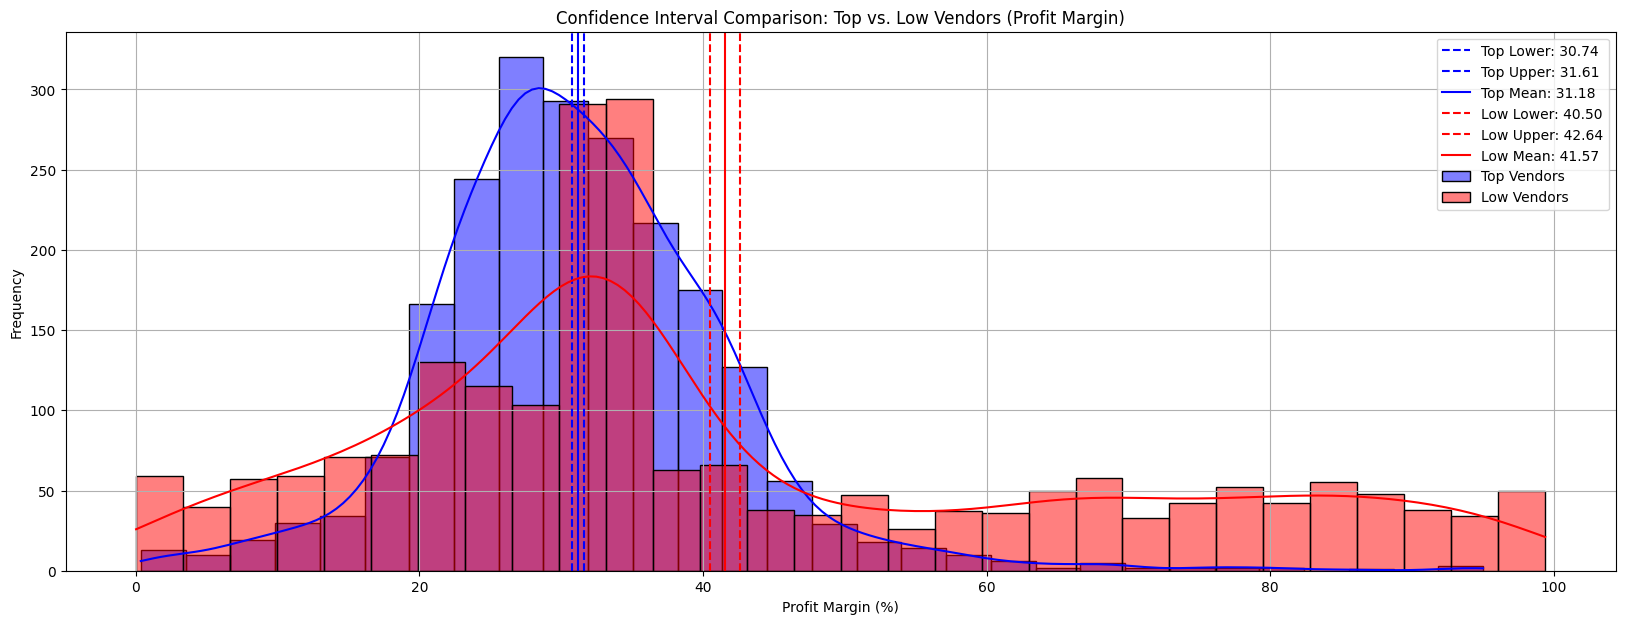

In [46]:
top_mean, top_lower, top_upper = confidence_interval(top_vendors)
low_mean, low_lower, low_upper = confidence_interval(low_vendors)

print(f"Top vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(20,7))

# Histogram Plot for Top Vendors:

sns.histplot(top_vendors,kde=True, color='blue', bins=30, alpha=0.5, label='Top Vendors')
plt.axvline(top_lower, color='blue', linestyle='--', label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color='blue', linestyle='--', label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color='blue', linestyle='-', label=f"Top Mean: {top_mean:.2f}")


# Histogram Plot for Low Vendors:

sns.histplot(low_vendors,kde=True, color='red', bins=30, alpha=0.5, label='Low Vendors')
plt.axvline(low_lower, color='red', linestyle='--', label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color='red', linestyle='--', label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color='red', linestyle='-', label=f"Low Mean: {low_mean:.2f}")


plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

- The confidence interval for low-performing vendors (40.48% to 42.62%) is considerably higher than that of top-performing vendors (30.74% to 31.61%).
- This indicates that vendors with lower sales often maintain higher profit margins, possibly due to premium pricing or reduced operational costs.
- For High-Performing Vendors: To enhance profitability, they could consider selective price adjustments, cost optimization, or bundling strategies.
- For Low-Performing Vendors: Despite having higher margins, their limited sales volume highlights the need for stronger marketing, competitive pricing, or improved distribution strategies.

### Is there a significant difference in profit margins between top-performing and low-performing vendors?
#### Hypothesis:
1. Ho (Null Hypothesis): There is no significant difference in the mean profit margins of top performing and low performing vendors
2. H1 (Alternate Hypothesis): The mean profit margin of top performing and non-performing vendors are significantly different.

In [47]:
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)
top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

# Performing Two-Sample Test:
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

print(f"T-Statistics: {t_stat:.4f}, P-Value: {p_value:.4f}")
if p_value < 0.05:
    print("Reject Ho: There is a significant difference in profit margins between top and low performing vendors.")
else:
    print("Fail to Reject Ho: No significant difference in profit margin.")

T-Statistics: -17.6693, P-Value: 0.0000
Reject Ho: There is a significant difference in profit margins between top and low performing vendors.


In [48]:
# For Power BI Dashboarding, exporting df in csv file.

# df.to_csv("vendorSummary.csv", index=False)